---

# Examen Final (Machine Learning Supervisado)
# Clasificación de Mortalidad Hospitalaria 

---
### Estudiante:

* Andrés Felipe Flórez Olivera
---

El entregable es un informe (Jupyter notebook) del procedimiento llevado a cabo para llegar a su modelo final. Este informe debe estar bien estructurado, e incluir la información requerida en la evaluación. Incluya gráficas y tablas que le permitan presentar la información de manera concisa y clara. El código debe estar bien estructurado y apropiadamente comentado.

In [2]:
!pip install missingno

In [189]:
# Manipulación de datos
import numpy as np
import pandas as pd
import scipy as sp
from scipy.stats import uniform, randint
import time
from random import random, seed

# Visualización de datos
import seaborn as sns
import matplotlib.pyplot as plt
import missingno as msno

# Cálculos estadísticos
import statsmodels.api as sm
import scipy.stats as stats

# Validación y preprocesamiento
from sklearn.pipeline import Pipeline
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler

# Modelos de clasificación
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
import xgboost as xgb
from xgboost.sklearn import XGBClassifier
from xgboost import plot_importance

# Submuestreo para datos desbalanceados
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler

# Validación de modelos
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold, StratifiedKFold, RepeatedStratifiedKFold
from sklearn.model_selection import cross_validate, cross_val_predict, cross_val_score

# Métricas de rendimiento
from sklearn.metrics import confusion_matrix, accuracy_score, recall_score
from sklearn.metrics import average_precision_score, precision_score
from sklearn.metrics import f1_score, classification_report
from sklearn.metrics import precision_recall_curve, roc_curve, auc
from sklearn.metrics import ConfusionMatrixDisplay

# Ignorar warnings
import warnings
warnings.filterwarnings("ignore")


In [4]:
# Carga de los datos
data = pd.read_csv("datos.csv")

In [5]:
# Ver la información del conjunto de datos
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9105 entries, 0 to 9104
Data columns (total 27 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Unnamed: 0  9105 non-null   int64  
 1   age         9105 non-null   float64
 2   sex         9105 non-null   object 
 3   dzgroup     9105 non-null   object 
 4   dzclass     9105 non-null   object 
 5   num.co      9105 non-null   int64  
 6   scoma       9104 non-null   float64
 7   avtisst     9023 non-null   float64
 8   race        9063 non-null   object 
 9   sps         9104 non-null   float64
 10  aps         9104 non-null   float64
 11  surv2m      9104 non-null   float64
 12  surv6m      9104 non-null   float64
 13  hday        9105 non-null   int64  
 14  diabetes    9105 non-null   int64  
 15  dementia    9105 non-null   int64  
 16  ca          9105 non-null   object 
 17  dnr         9075 non-null   object 
 18  dnrday      9075 non-null   float64
 19  meanbp      9104 non-null  

In [6]:
 # Para obtener estadísticas generales del dataset
 data.describe()

,Unnamed: 0,age,num.co,scoma,avtisst,sps,aps,surv2m,surv6m,hday,...,dementia,dnrday,meanbp,hrt,resp,temp,crea,sod,adlsc,hospdead
count,9105.000000,9105.000000,9105.000000,9104.000000,9023.000000,9104.000000,9104.000000,9104.000000,9104.000000,9105.000000,...,9105.000000,9075.000000,9104.000000,9104.000000,9104.000000,9104.000000,9038.000000,9104.000000,9105.000000,9105.000000
mean,4552.000000,62.650823,1.868644,12.058546,22.610928,25.525872,37.597979,0.635870,0.520096,4.400000,...,0.032510,14.582590,84.546408,97.156711,23.330294,37.103341,1.770961,137.568541,1.888272,0.259198
std,2628.531434,15.593710,1.344409,24.636694,13.233248,9.899377,19.903852,0.248175,0.253343,9.126811,...,0.177359,19.944216,27.687692,31.559292,9.573801,1.251796,1.686041,6.029326,2.003763,0.438219
min,0.000000,18.041990,0.000000,0.000000,1.000000,0.199982,0.000000,0.000000,0.000000,1.000000,...,0.000000,-88.000000,0.000000,0.000000,0.000000,31.699220,0.099991,110.000000,0.000000,0.000000
25%,2276.000000,52.797000,1.000000,0.000000,12.000000,19.000000,23.000000,0.507690,0.342957,1.000000,...,0.000000,4.000000,63.000000,72.000000,18.000000,36.195310,0.899902,134.000000,0.000000,0.000000
50%,4552.000000,64.856990,2.000000,0.000000,19.500000,23.898438,34.000000,0.715942,0.574951,1.000000,...,0.000000,9.000000,77.000000,100.000000,24.000000,36.695310,1.199951,137.000000,1.000000,0.000000
75%,6828.000000,73.998960,3.000000,9.000000,31.666656,30.199219,49.000000,0.825928,0.725952,3.000000,...,0.000000,17.000000,107.000000,120.000000,28.000000,38.195310,1.899902,141.000000,3.000000,1.000000
max,9104.000000,101.847960,9.000000,100.000000,83.000000,99.187500,143.000000,0.969971,0.947998,148.000000,...,1.000000,285.000000,195.000000,300.000000,90.000000,41.695310,21.500000,181.000000,7.073242,1.000000


In [7]:
data.head()

,Unnamed: 0,age,sex,dzgroup,dzclass,num.co,scoma,avtisst,race,sps,...,dnr,dnrday,meanbp,hrt,resp,temp,crea,sod,adlsc,hospdead
0,0,62.84998,male,Lung Cancer,Cancer,0,0.0,7.000000,other,33.898438,...,no dnr,5.0,97.0,69.0,22.0,36.00000,1.199951,141.0,7.0,0
1,1,60.33899,female,Cirrhosis,COPD/CHF/Cirrhosis,2,44.0,29.000000,white,52.695312,...,NaN,NaN,43.0,112.0,34.0,34.59375,5.500000,132.0,1.0,1
2,2,52.74698,female,Cirrhosis,COPD/CHF/Cirrhosis,2,0.0,13.000000,white,20.500000,...,no dnr,17.0,70.0,88.0,28.0,37.39844,2.000000,134.0,0.0,0
3,3,42.38498,female,Lung Cancer,Cancer,2,0.0,7.000000,white,20.097656,...,no dnr,3.0,75.0,88.0,32.0,35.00000,0.799927,139.0,0.0,0
4,4,79.88495,female,ARF/MOSF w/Sepsis,ARF/MOSF,1,26.0,18.666656,white,23.500000,...,no dnr,16.0,59.0,112.0,20.0,37.89844,0.799927,143.0,2.0,0


In [8]:
# Observamos que los datos tienen incorporada una columna ID, por lo tanto se puede eliminar:
data = data.drop(data.columns[0], axis=1)

In [9]:
data.head()

,age,sex,dzgroup,dzclass,num.co,scoma,avtisst,race,sps,aps,...,dnr,dnrday,meanbp,hrt,resp,temp,crea,sod,adlsc,hospdead
0,62.84998,male,Lung Cancer,Cancer,0,0.0,7.000000,other,33.898438,20.0,...,no dnr,5.0,97.0,69.0,22.0,36.00000,1.199951,141.0,7.0,0
1,60.33899,female,Cirrhosis,COPD/CHF/Cirrhosis,2,44.0,29.000000,white,52.695312,74.0,...,NaN,NaN,43.0,112.0,34.0,34.59375,5.500000,132.0,1.0,1
2,52.74698,female,Cirrhosis,COPD/CHF/Cirrhosis,2,0.0,13.000000,white,20.500000,45.0,...,no dnr,17.0,70.0,88.0,28.0,37.39844,2.000000,134.0,0.0,0
3,42.38498,female,Lung Cancer,Cancer,2,0.0,7.000000,white,20.097656,19.0,...,no dnr,3.0,75.0,88.0,32.0,35.00000,0.799927,139.0,0.0,0
4,79.88495,female,ARF/MOSF w/Sepsis,ARF/MOSF,1,26.0,18.666656,white,23.500000,30.0,...,no dnr,16.0,59.0,112.0,20.0,37.89844,0.799927,143.0,2.0,0


In [10]:
# Una vez hecha esta eliminación, podemos observar la forma resultante del dataframe:
print(data.shape)

(9105, 26)


# Tratamiento del dataframe

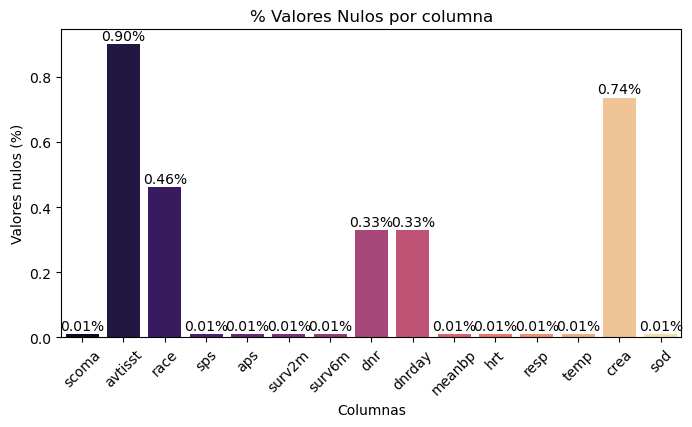

In [13]:
# Calcular el porcentaje de valores nulos en un solo paso
null_percentage = (data.isnull().mean() * 100)

# Filtrar columnas con valores nulos
null_percentage = null_percentage[null_percentage > 0]

# Graficar el porcentaje de valores nulos
plt.figure(figsize=(8, 4))
ax = sns.barplot(x=null_percentage.index, y=null_percentage.values, palette='magma')

# Añadir etiquetas en cada barra mostrando el porcentaje
for p in ax.patches:
    ax.annotate(f'{p.get_height():.2f}%', 
                (p.get_x() + p.get_width() / 2., p.get_height()), 
                ha='center', va='baseline', 
                fontsize=10, color='black', xytext=(0, 3), 
                textcoords='offset points')

plt.title('% Valores Nulos por columna')
plt.xlabel('Columnas')
plt.ylabel('Valores nulos (%)')
plt.xticks(rotation=45)
plt.show()

Requerimos trabajar variables numéricas únicamente, por lo tanto podemos eliminar variables categóricas

In [24]:
# Eliminar variables categóricas del DataFrame
data_numeric = data.select_dtypes(exclude=['object', 'category'])

# Mostrar las primeras filas para verificar el nuevo DataFrame sin categóricas
data_numeric.head()

,age,num.co,scoma,avtisst,sps,aps,surv2m,surv6m,hday,diabetes,dementia,dnrday,meanbp,hrt,resp,temp,crea,sod,adlsc,hospdead
0,62.84998,0,0.0,7.000000,33.898438,20.0,0.262939,0.036995,1,0,0,5.0,97.0,69.0,22.0,36.00000,1.199951,141.0,7.0,0
1,60.33899,2,44.0,29.000000,52.695312,74.0,0.001000,0.000000,3,0,0,NaN,43.0,112.0,34.0,34.59375,5.500000,132.0,1.0,1
2,52.74698,2,0.0,13.000000,20.500000,45.0,0.790894,0.664917,4,0,0,17.0,70.0,88.0,28.0,37.39844,2.000000,134.0,0.0,0
3,42.38498,2,0.0,7.000000,20.097656,19.0,0.698975,0.411987,1,0,0,3.0,75.0,88.0,32.0,35.00000,0.799927,139.0,0.0,0
4,79.88495,1,26.0,18.666656,23.500000,30.0,0.634888,0.532959,3,0,0,16.0,59.0,112.0,20.0,37.89844,0.799927,143.0,2.0,0


Ahora calculamos porcentaje de nulidad de cada variable numerica restante:

In [27]:
def null_classifier(data):
    # Cálculo de número y porcentaje de valores nulos
    null_counts = data.isnull().sum()
    null_percentage = (null_counts / len(data)) * 100

    # Filtrar las columnas con valores nulos
    null_counts = null_counts[null_counts > 0]
    null_percentage = null_percentage[null_percentage > 0]

    # Crear dataframe con valores relevantes
    nulls = pd.DataFrame({
        'Variable': null_counts.index,
        'Porcentaje de valores nulos': null_percentage.values,
        'Cantidad de valores nulos': null_counts.values
    })

    # Ordenar por porcentaje de valores nulos
    nulls = nulls.sort_values(by='Porcentaje de valores nulos', ascending=False)
    
    return nulls

# Llamar a la función
null_classifier(data)


,Variable,Porcentaje de valores nulos,Cantidad de valores nulos
1,avtisst,0.900604,82
13,crea,0.735859,67
2,race,0.461285,42
7,dnr,0.329489,30
8,dnrday,0.329489,30
0,scoma,0.010983,1
3,sps,0.010983,1
4,aps,0.010983,1
5,surv2m,0.010983,1
6,surv6m,0.010983,1


In [29]:
# Función para eliminar datos nulos y luego identificar duplicados
def transformation_one(data):
    # Eliminar filas con valores nulos
    df_non_nan = data.dropna()
    
    # Identificar el número de duplicados
    duplicated_rows = df_non_nan.duplicated().sum()
    
    # Mostrar información
    print('Dimensiones de los datos después de eliminar nulos =', df_non_nan.shape)
    print('El número de filas duplicadas es =', duplicated_rows)
    print('El porcentaje de filas duplicadas es =', np.round((duplicated_rows * 100) / len(df_non_nan), 4))
    
    return df_non_nan

# Llamar a la función
df_clean = transformation_one(data)

Dimensiones de los datos después de eliminar nulos = (8888, 26)
El número de filas duplicadas es = 0
El porcentaje de filas duplicadas es = 0.0


In [44]:
df_clean.info()

<class 'pandas.core.frame.DataFrame'>
Index: 8888 entries, 0 to 9104
Data columns (total 26 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       8888 non-null   float64
 1   sex       8888 non-null   object 
 2   dzgroup   8888 non-null   object 
 3   dzclass   8888 non-null   object 
 4   num.co    8888 non-null   int64  
 5   scoma     8888 non-null   float64
 6   avtisst   8888 non-null   float64
 7   race      8888 non-null   object 
 8   sps       8888 non-null   float64
 9   aps       8888 non-null   float64
 10  surv2m    8888 non-null   float64
 11  surv6m    8888 non-null   float64
 12  hday      8888 non-null   int64  
 13  diabetes  8888 non-null   int64  
 14  dementia  8888 non-null   int64  
 15  ca        8888 non-null   object 
 16  dnr       8888 non-null   object 
 17  dnrday    8888 non-null   float64
 18  meanbp    8888 non-null   float64
 19  hrt       8888 non-null   float64
 20  resp      8888 non-null   float64
 

In [41]:
# Descripción de los datos numéricos
df_clean.select_dtypes(include=[np.number]).describe()

,age,num.co,scoma,avtisst,sps,aps,surv2m,surv6m,hday,diabetes,dementia,dnrday,meanbp,hrt,resp,temp,crea,sod,adlsc,hospdead
count,8888.000000,8888.000000,8888.000000,8888.000000,8888.000000,8888.000000,8888.000000,8888.000000,8888.000000,8888.000000,8888.000000,8888.000000,8888.000000,8888.000000,8888.000000,8888.000000,8888.000000,8888.000000,8888.000000,8888.000000
mean,62.649543,1.868924,12.056818,22.623733,25.597739,37.750450,0.635254,0.519799,4.428555,0.195207,0.032853,14.758213,84.599179,97.254241,23.316044,37.104381,1.771418,137.557268,1.886694,0.260014
std,15.608807,1.346400,24.604668,13.221998,9.816206,19.791152,0.247701,0.253048,9.184803,0.396382,0.178263,20.063457,27.754427,31.560496,9.579744,1.251883,1.685958,6.053165,2.009061,0.438666
min,18.041990,0.000000,0.000000,1.000000,1.199951,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,-88.000000,0.000000,0.000000,0.000000,31.699220,0.099991,110.000000,0.000000,0.000000
25%,52.766245,1.000000,0.000000,12.000000,19.097656,23.000000,0.506958,0.341980,1.000000,0.000000,0.000000,4.000000,63.000000,72.000000,18.000000,36.195310,0.899902,134.000000,0.000000,0.000000
50%,64.888455,2.000000,0.000000,19.666656,24.000000,35.000000,0.714966,0.574951,1.000000,0.000000,0.000000,9.000000,77.000000,100.000000,24.000000,36.695310,1.199951,137.000000,1.000000,0.000000
75%,74.036745,3.000000,9.000000,31.666656,30.199219,49.000000,0.825195,0.724976,4.000000,0.000000,0.000000,17.000000,107.000000,120.000000,28.000000,38.195310,1.899902,141.000000,3.000000,1.000000
max,100.849000,9.000000,100.000000,83.000000,99.187500,143.000000,0.966919,0.943970,148.000000,1.000000,1.000000,285.000000,195.000000,300.000000,90.000000,41.695310,21.500000,181.000000,7.073242,1.000000


# Análisis Exploratorio de Datos

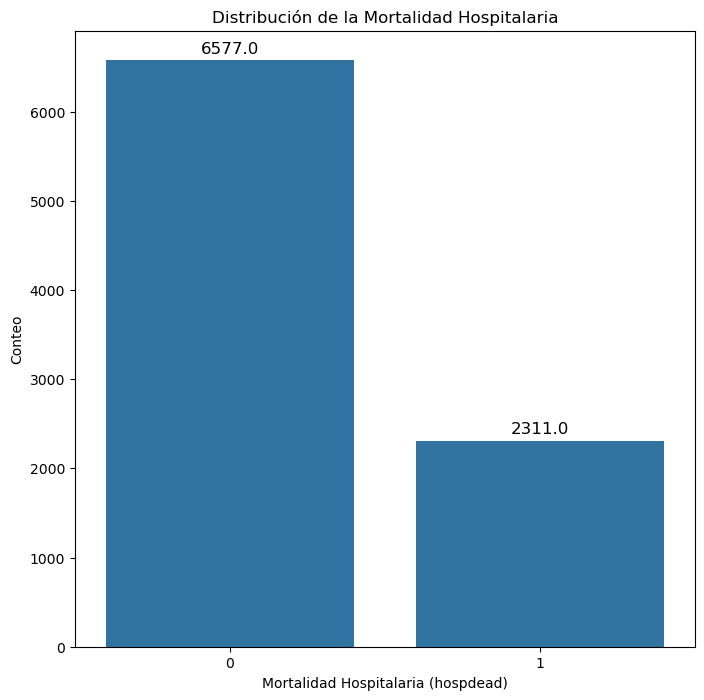

In [73]:
# Distribución de la variable objetivo 'hospdead'
plt.figure(figsize=(8,8))
ax = sns.countplot(x='hospdead', data=df_clean)
plt.title("Distribución de la Mortalidad Hospitalaria")
plt.xlabel("Mortalidad Hospitalaria (hospdead)")
plt.ylabel("Conteo")

for p in ax.patches:
    ax.annotate(f'{p.get_height()}', 
                (p.get_x() + p.get_width() / 2., p.get_height()), 
                ha='center', va='baseline', fontsize=12, color='black', 
                xytext=(0, 5), textcoords='offset points')

plt.show()

hospdead
0    6577
1    2311
Name: count, dtype: int64


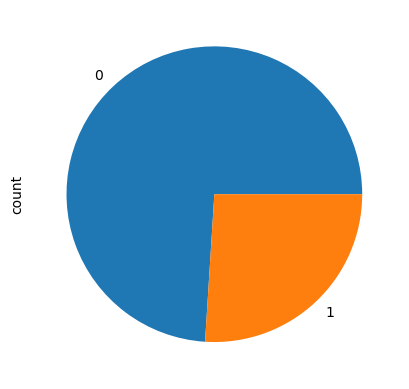

In [78]:
#Balance de la variable objetivo
df_clean['hospdead'].value_counts().plot(kind='pie')
print(df_clean['hospdead'].value_counts())

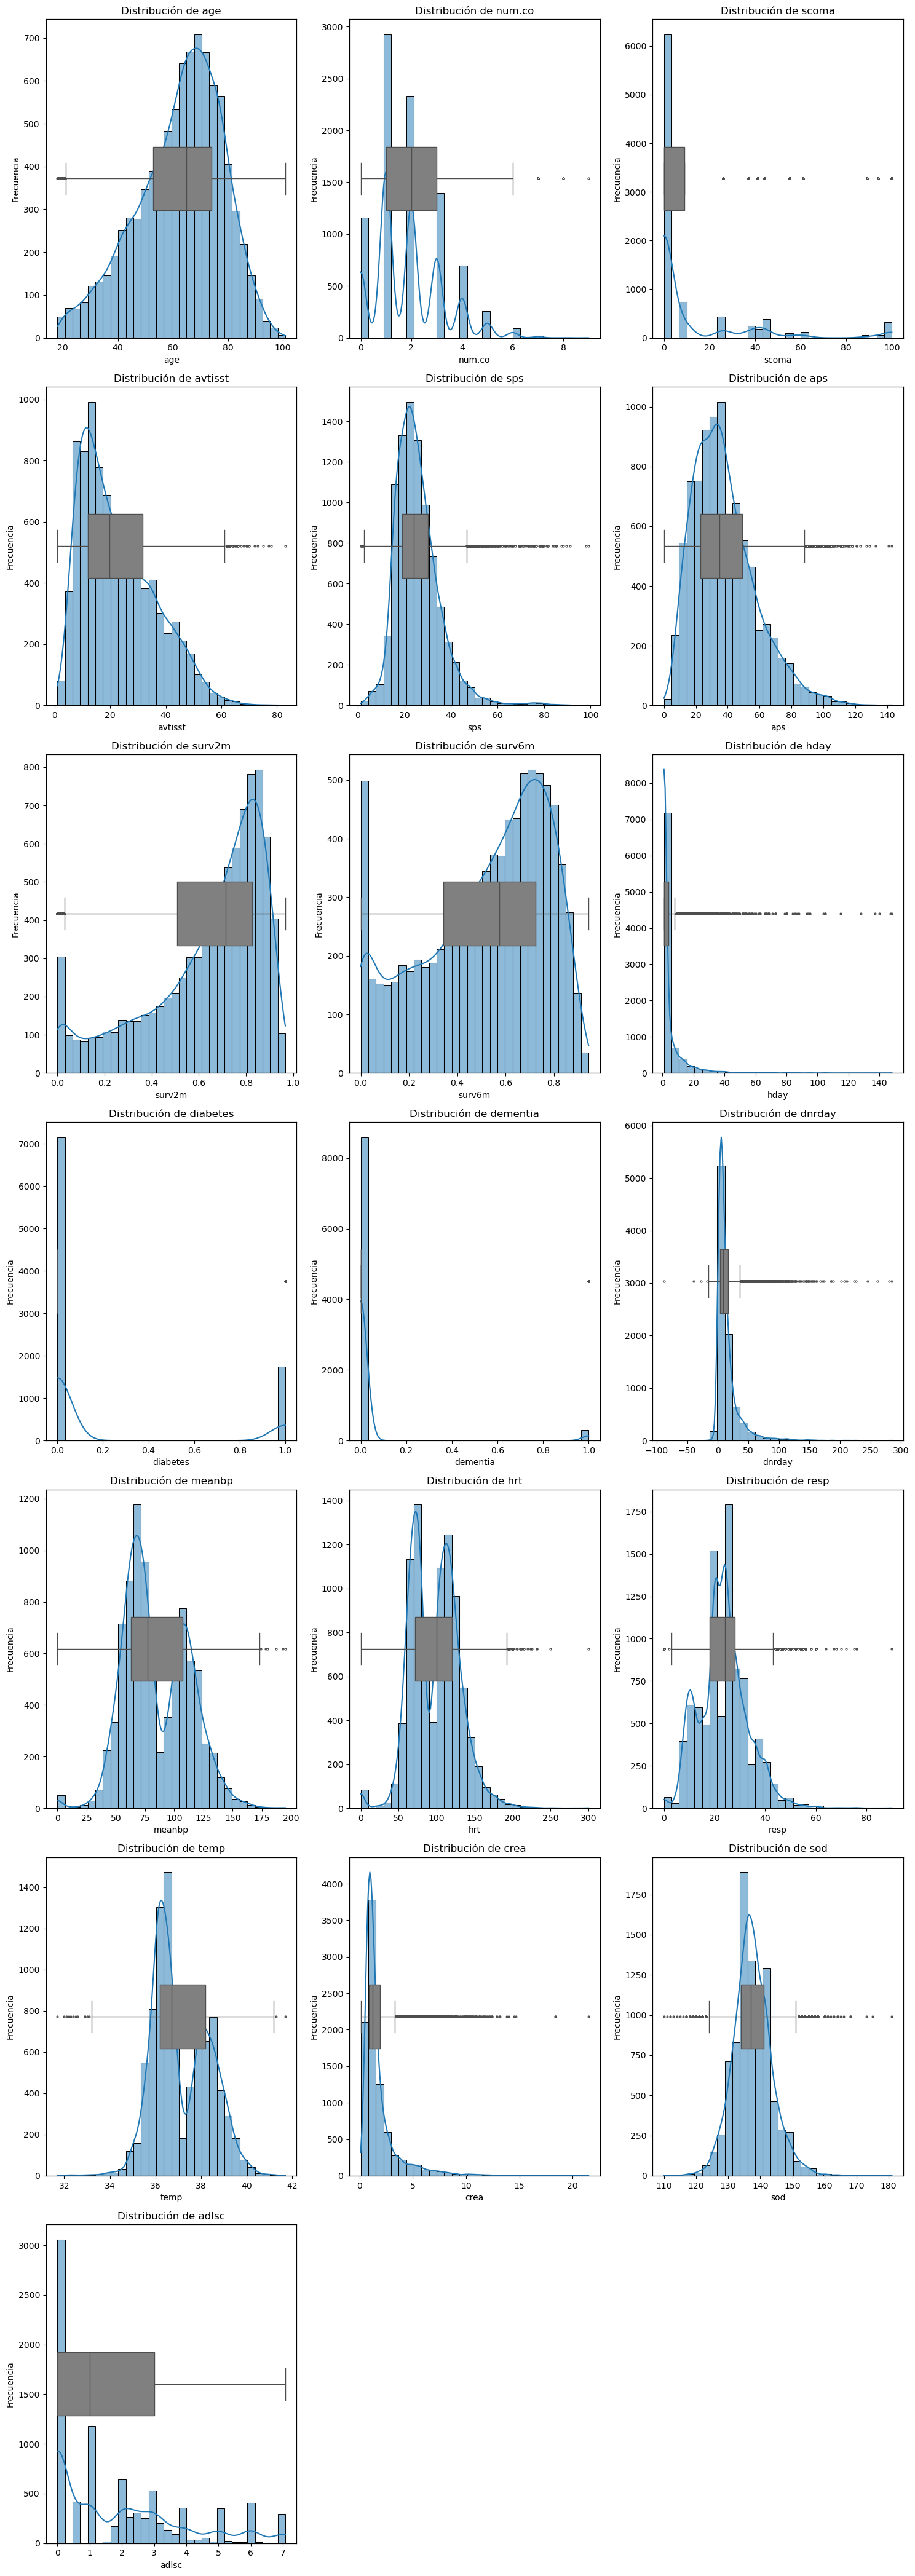

In [86]:
# Utilizamos la variable objetivo y la variable sex para extender nuestro análisis:
binary_var = ['hospdead', 'sex']

# Ahora puedes ejecutar el análisis sin problemas
def analysis(df, exclude_vars=None, ncols=3):
    if exclude_vars:
        df = df.drop(columns=exclude_vars, errors='ignore')

    # Seleccionar solo columnas numéricas (enteros y floats)
    num_cols = df.select_dtypes(include=['float64', 'int64']).columns

    n = len(num_cols)
    nrows = int(np.ceil(n / ncols))

    fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(15, nrows * 6))

    axes = axes.flatten()

    # Graficar histogramas y boxplots para cada variable numérica
    for i, col in enumerate(num_cols):
        ax_hist = axes[i]  # Eje para el histograma
        sns.histplot(df[col], kde=True, bins=30, ax=ax_hist)
        ax_hist.set_title(f'Distribución de {col}')
        ax_hist.set_xlabel(col)
        ax_hist.set_ylabel('Frecuencia')

        ax_box = ax_hist.twinx()
        sns.boxplot(x=df[col], ax=ax_box, color='gray', width=0.2, fliersize=2)
        ax_box.set(yticks=[], ylabel=None)

    plt.tight_layout()

    for j in range(i + 1, nrows * ncols):
        fig.delaxes(axes[j])

    plt.show()

# Ejecutar el análisis
analysis(df=df_clean, exclude_vars=binary_var, ncols=3)

In [101]:
print(df_clean.columns)

Index(['age', 'sex', 'dzgroup', 'dzclass', 'num.co', 'scoma', 'avtisst',
       'race', 'sps', 'aps', 'surv2m', 'surv6m', 'hday', 'diabetes',
       'dementia', 'ca', 'dnr', 'dnrday', 'meanbp', 'hrt', 'resp', 'temp',
       'crea', 'sod', 'adlsc', 'hospdead'],
      dtype='object')


De acuerdo con los gráficos de distribución, podemos observar que la variable con mayor sesgo es **scoma**, seguida por **hday**, que también presenta un alto sesgo además de una notable presencia de outliers. A continuación, está **dnrday**, que muestra un alto nivel de sesgo y contiene outliers. La variable **crea** también exhibe un sesgo considerable junto con la presencia de outliers. Luego, encontramos **sdlsc**, que presenta un alto sesgo.

Por otro lado, las variables **aps** y **sps** son relevantes principalmente por la gran cantidad de outliers, aunque **aps** muestra un leve sesgo. **resp** sigue mostrando más presencia de outliers que de sesgo. **sod** tiene una distribución simétrica, pero contiene muchos outliers.

Finalmente, las variables **meanbp**, **hrt** y **temp** se comportan como distribuciones bimodales, sin un sesgo claro, pero con características particulares en su forma.

In [122]:
# Detección y tratamiento de outliers usando el rango intercuartílico
for column in df_clean.select_dtypes(include=[np.number]).columns:
    q1 = df_clean[column].quantile(0.25)
    q3 = df_clean[column].quantile(0.75)
    iqr = q3 - q1
    lower_bound = q1 - 1.5 * iqr
    upper_bound = q3 + 1.5 * iqr

    # Contar outliers
    outliers = df_clean[(df_clean[column] < lower_bound) | (df_clean[column] > upper_bound)]
    if len(outliers) > 1000:
        temp_mean = df_clean[column].mean()
        df_clean.loc[df_clean[column] < lower_bound, column] = temp_mean
        df_clean.loc[df_clean[column] > upper_bound, column] = temp_mean
        print(f"Imputados {len(outliers)} outliers en la columna: {column}, con el promedio: {temp_mean}")

Imputados 1910 outliers en la columna: scoma, con el promedio: 12.056818181818182
Imputados 1208 outliers en la columna: hday, con el promedio: 4.428555355535553
Imputados 1735 outliers en la columna: diabetes, con el promedio: 0.19520702070207022


Ahora bien, considerando el desbalance de las variables, podemos observar su comportamiento:

sex
male      0.563006
female    0.436994
Name: count, dtype: float64


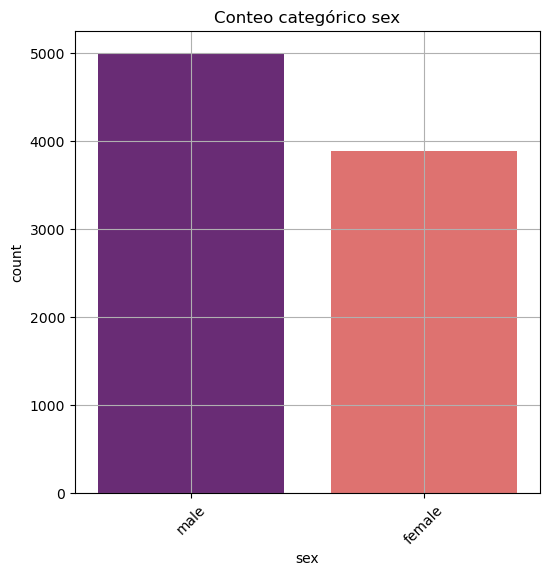

dzgroup
ARF/MOSF w/Sepsis    0.389289
CHF                  0.152453
COPD                 0.105986
Lung Cancer          0.097097
MOSF w/Malig         0.077970
Coma                 0.065819
Cirrhosis            0.056368
Colon Cancer         0.055018
Name: count, dtype: float64


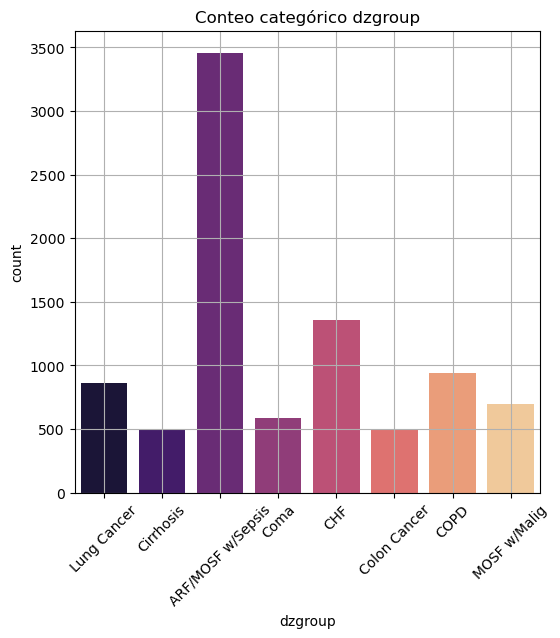

dzclass
ARF/MOSF              0.467259
COPD/CHF/Cirrhosis    0.314806
Cancer                0.152115
Coma                  0.065819
Name: count, dtype: float64


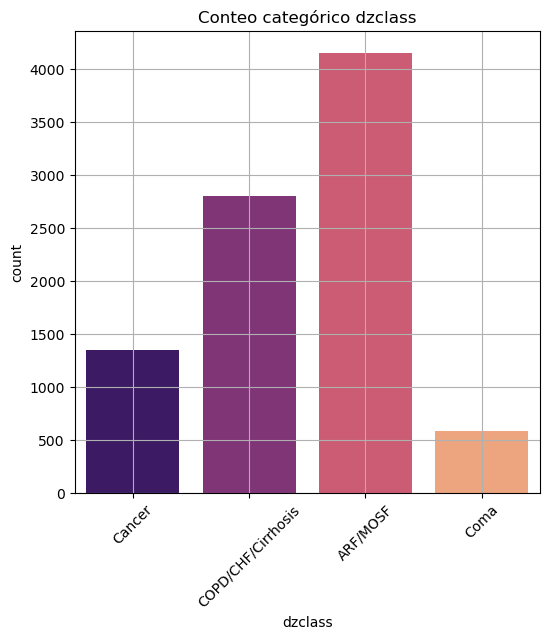

race
white       0.792417
black       0.153803
hispanic    0.032628
other       0.012264
asian       0.008888
Name: count, dtype: float64


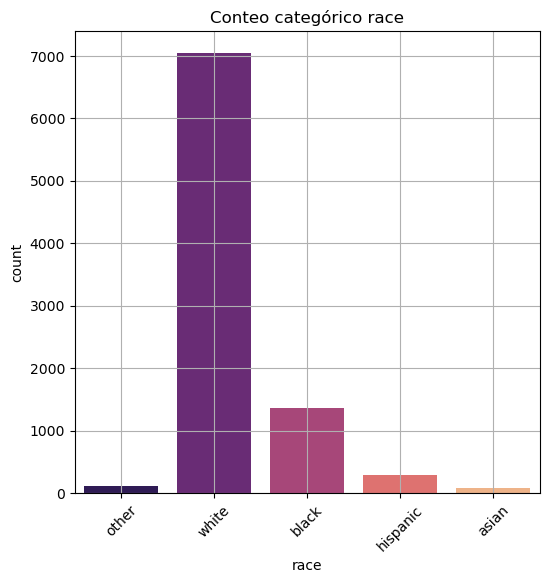

ca
no            0.662129
metastatic    0.200270
yes           0.137601
Name: count, dtype: float64


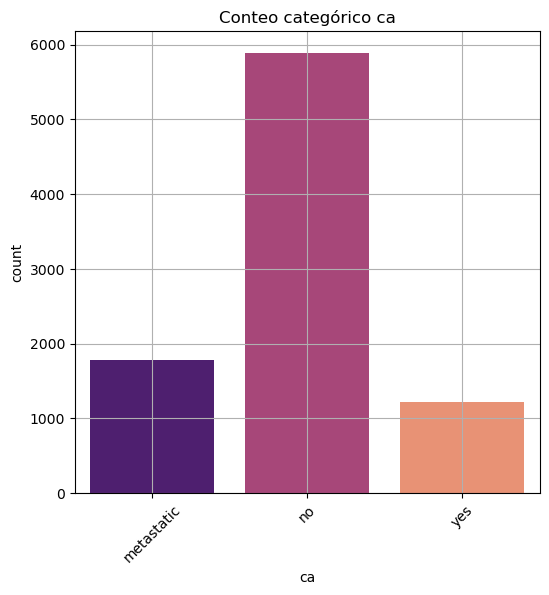

dnr
no dnr             0.647277
dnr after sadm     0.327295
dnr before sadm    0.025428
Name: count, dtype: float64


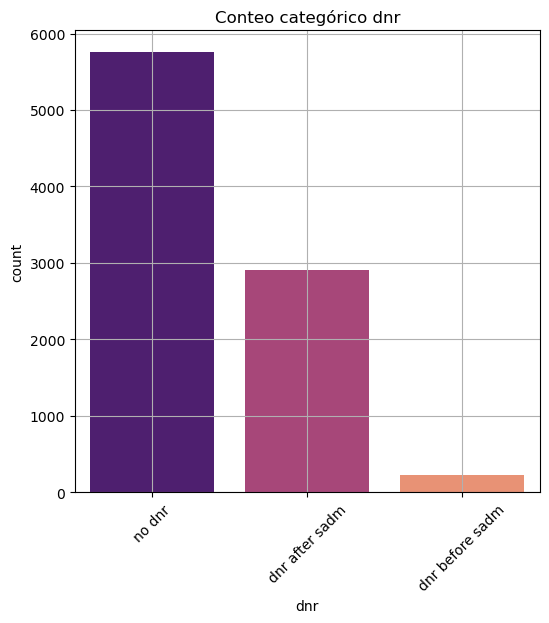

In [131]:
# Conteos categóricos
for variable in df_clean.select_dtypes(include=['object']).columns:
    print(df_clean[variable].value_counts()/len(df_clean))
    plt.figure(figsize=(6,6))
    sns.countplot(data=df_clean,x=variable, palette = 'magma')
    plt.title(f'Conteo categórico {variable}')
    plt.xticks(rotation=45)
    plt.grid()
    plt.show()

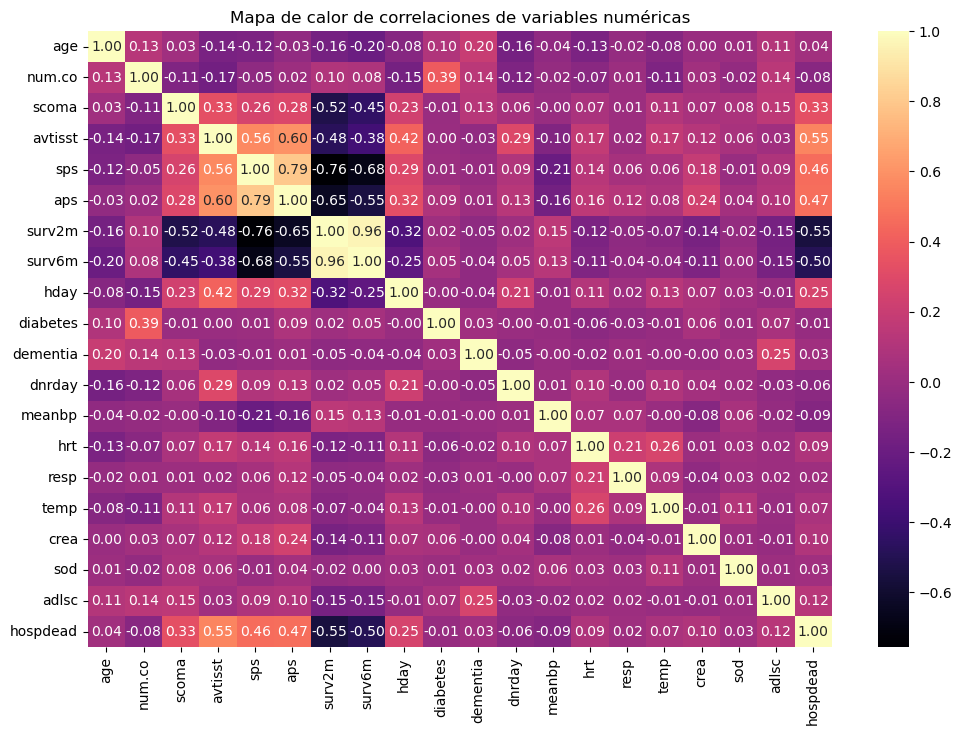

In [144]:
# Seleccionar solo las columnas numéricas
df_numeric = df_clean.select_dtypes(include=[float, int])

# Calcular la matriz de correlación
correlation_matrix = df_numeric.corr()

# Graficar el mapa de calor
plt.figure(figsize=(12, 8))
sns.heatmap(correlation_matrix, annot=True, fmt='.2f', cmap='magma')
plt.title("Mapa de calor de correlaciones de variables numéricas")
plt.show()

**Análisis:** 
Teniendo en cuenta las observaciones previas y el diccionario de datos: https://spartan-119.github.io/SUPPORT2/data_quality.html, se plantea que para predecir la mortalidad hospitalaria de pacientes críticamente enfermos se pueden seguir dos enfoques: entrenar un modelo que incluya todas las variables disponibles o seleccionar únicamente aquellas que contribuyen de manera más significativa a la predicción. Al analizar la naturaleza del problema y la información contenida en el dataset, se considera que las características más importantes están relacionadas con el estado de salud y la gravedad del paciente, así como con el desenlace hospitalario.

Entre las variables más relevantes destacan algunas que están estrechamente vinculadas con el estado crítico del paciente. Por ejemplo, el puntaje de coma en el día 3 (scoma) se relaciona con la función neurológica y puede ser un indicador de supervivencia, mientras que la puntuación de APACHE III (aps) mide la gravedad de la enfermedad en la UCI y predice el riesgo de mortalidad. Otras variables incluyen el puntaje TISS (avtisst), que refleja el número de intervenciones terapéuticas recibidas, y las estimaciones de supervivencia a 2 y 6 meses (surv2m/surv6m), que proporcionan predicciones sobre la probabilidad de supervivencia basadas en el modelo SUPPORT. Además, variables como la presión arterial media (meanbp), la frecuencia cardíaca (hrt) y los niveles de creatinina (crea) son indicadores fisiológicos que pueden estar correlacionados con la estabilidad hemodinámica, el deterioro clínico y la función renal, respectivamente.

Otras variables importantes incluyen la temperatura corporal (temp), que puede reflejar infecciones o inestabilidad metabólica, y el número de comorbilidades (num.co), que mide la carga de enfermedades adicionales, aumentando el riesgo de mortalidad. También se destacan el índice de actividades diarias (adls), que indica la capacidad funcional del paciente, la presencia de cáncer metastásico (ca), y la edad (age), que influye en la capacidad del paciente para soportar enfermedades y tratamientos. Finalmente, se consideran otras variables como la diabetes, que aunque relevante, podría ser menos determinante que otros factores más graves, y la variable objetivo de mortalidad hospitalaria (hospdead).

Existen otras variables de relevancia moderada o baja que, aunque no directamente vinculadas a la gravedad o a la probabilidad de mortalidad, podrían aportar información adicional. Entre ellas, el género (sex) y la raza (race), que podrían tener alguna influencia en los resultados de salud aunque con una relación menos directa con la mortalidad. El día de ingreso al estudio (hday) y la fecha de la orden de no resucitar (dnrday) podrían ser importantes en el análisis temporal, pero su impacto directo sobre la mortalidad es limitado. Los niveles de sodio (sod) pueden ser indicativos en casos de disfunción metabólica, pero no son tan influyentes como otros indicadores. Finalmente, el estado "No Resucitar" (dnr), aunque puede reflejar una decisión crítica de los familiares y sugerir un estado crítico del paciente, no afecta directamente su salud.

In [147]:
# Correlaciones con la columna objetivo (hospdead)
if 'hospdead' in correlation_matrix.columns:
    corr_target = correlation_matrix['hospdead'].sort_values(ascending=False)
    print(f"Correlaciones con 'hospdead':\n{corr_target}")
else:
    print("La columna 'hospdead' no está en la matriz de correlación.")

Correlaciones con 'hospdead':
hospdead    1.000000
avtisst     0.552002
aps         0.470715
sps         0.458628
scoma       0.329480
hday        0.253596
adlsc       0.124985
crea        0.096904
hrt         0.093318
temp        0.071523
age         0.039207
sod         0.030094
dementia    0.026011
resp        0.021117
diabetes   -0.013670
dnrday     -0.057510
num.co     -0.076414
meanbp     -0.085659
surv6m     -0.495085
surv2m     -0.554345
Name: hospdead, dtype: float64


In [159]:
# Variables mas correlacionadas con el objetivo
features = ['avtisst', 'aps', 'sps', 'scoma', 'hday', 'surv2m', 'surv6m']
X = df_clean[features]
y = df_clean['hospdead']

# Dividir los datos en conjuntos de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=58)

# Verificar las dimensiones de los conjuntos de datos
print(f"Tamaño de X_train: {X_train.shape}")
print(f"Tamaño de X_test: {X_test.shape}")
print(f"Tamaño de y_train: {y_train.shape}")
print(f"Tamaño de y_test: {y_test.shape}")

Tamaño de X_train: (7110, 7)
Tamaño de X_test: (1778, 7)
Tamaño de y_train: (7110,)
Tamaño de y_test: (1778,)


# Modelos de Machine Learning Aplicados

## Random Forest

In [172]:
# Crear y entrenar el modelo RandomForest
rf_classifier = RandomForestClassifier(random_state=58, n_estimators=100).fit(X_train, y_train)

# Hacer predicciones en los datos de prueba
y_pred = rf_classifier.predict(X_test)

# Evaluar el rendimiento del modelo
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy del modelo: {accuracy:.4f}")

# Mostrar la matriz de confusión con etiquetas más descriptivas
cm = confusion_matrix(y_test, y_pred)
print(f"\nMatriz de confusión:\n{cm}")

# Mostrar el informe de clasificación
print("\nInforme de clasificación:")
print(classification_report(y_test, y_pred, zero_division=0))

# Calcular y mostrar otras métricas relevantes
precision = precision_score(y_test, y_pred, average='weighted', zero_division=0)
recall = recall_score(y_test, y_pred, average='weighted', zero_division=0)
f1 = f1_score(y_test, y_pred, average='weighted', zero_division=0)

print(f"\nPrecision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")

Accuracy del modelo: 0.8465

Matriz de confusión:
[[1225   94]
 [ 179  280]]

Informe de clasificación:
              precision    recall  f1-score   support

           0       0.87      0.93      0.90      1319
           1       0.75      0.61      0.67       459

    accuracy                           0.85      1778
   macro avg       0.81      0.77      0.79      1778
weighted avg       0.84      0.85      0.84      1778


Precision: 0.8405
Recall: 0.8465
F1 Score: 0.8410


## XGBoost

In [174]:
# Inicializar el modelo XGBoost
model = xgb.XGBClassifier(random_state=58)

# Inicializar el instrumento de cross validation
kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=58)

# Establecer las métricas de evaluación
scoring = ['accuracy', 'precision_weighted', 'recall_weighted', 'f1_weighted']

# Realizar validación cruzada con múltiples métricas
scores = cross_validate(model, X, y, cv=kfold, scoring=scoring, verbose=10, n_jobs=-1)

# Mostrar los resultados promedio de cada métrica
print(f"\nResultados promedio de las métricas tras la validación cruzada:")
for metric in scoring:
    mean_score = scores[f'test_{metric}'].mean()
    std_score = scores[f'test_{metric}'].std()
    print(f"{metric.capitalize()}: {mean_score:.4f} (+/- {std_score:.4f})")


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.



Resultados promedio de las métricas tras la validación cruzada:
Accuracy: 0.8376 (+/- 0.0076)
Precision_weighted: 0.8324 (+/- 0.0080)
Recall_weighted: 0.8376 (+/- 0.0076)
F1_weighted: 0.8339 (+/- 0.0078)


[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    2.2s remaining:    3.4s
[Parallel(n_jobs=-1)]: Done   3 out of   5 | elapsed:    2.2s remaining:    1.4s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    2.2s finished


In [176]:
def report_best_scores(results, n_top=3):
    for i in range(1, n_top + 1):
        candidates = np.flatnonzero(results['rank_test_score'] == i)
        for candidate in candidates:
            print(f"Model with rank: {i}")
            print(f"Mean validation score: {results['mean_test_score'][candidate]:.3f} "
                  f"(std: {results['std_test_score'][candidate]:.3f})")
            print(f"Parameters: {results['params'][candidate]}")
            print("-" * 50)
    
    # Retorna los parámetros del mejor modelo basado en la métrica principal
    return results['params'][np.argmin(results['rank_test_score'])]

def see_results(results):
    # Filtrar las columnas que no contienen los resultados de los splits
    filtered_results = results[results.columns.drop(list(results.filter(regex='split')))]
    
    # Mostrar los resultados ordenados por el ranking del score
    display(filtered_results.sort_values("rank_test_score"))


### Aplicación de Random Search

In [181]:
# Definir los parámetros para la búsqueda aleatoria
param_dist = {
    'n_estimators': randint(50, 200),
    'learning_rate': uniform(0.05, 1),
    'max_depth': randint(1, 20),
    'reg_lambda': uniform(0, 20)  # Regularización L2
}

# Inicializar la búsqueda aleatoria con el kfold definido anteriormente
search = RandomizedSearchCV(
    estimator=model,
    param_distributions=param_dist,
    n_iter=20, 
    scoring='accuracy', 
    cv=kfold, 
    verbose=10, 
    n_jobs=-1, 
    random_state=58
)

# Ajustar el modelo a los datos
search.fit(X, y)

# Convertir los resultados en un DataFrame para visualizar
results = pd.DataFrame(search.cv_results_)

# Mostrar los mejores resultados y obtener los parámetros del mejor modelo
see_results(results)
best_model_params = report_best_scores(search.cv_results_)
print("Mejores parámetros del modelo:", best_model_params)


Fitting 5 folds for each of 20 candidates, totalling 100 fits


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_learning_rate,param_max_depth,param_n_estimators,param_reg_lambda,params,mean_test_score,std_test_score,rank_test_score
13,0.170721,0.005368,0.009187,0.002289,0.181706,1,135,17.716464,"{'learning_rate': 0.18170585545383017, 'max_de...",0.848899,0.007899,1
7,0.156139,0.013739,0.009053,0.004262,0.214792,4,77,2.459996,"{'learning_rate': 0.21479237442327798, 'max_de...",0.848224,0.007389,2
4,0.148918,0.007192,0.012099,0.002208,0.350044,1,117,2.965449,"{'learning_rate': 0.35004370673357227, 'max_de...",0.847099,0.007181,3
9,0.219180,0.006936,0.015610,0.004750,0.918067,2,149,13.269423,"{'learning_rate': 0.9180671789167176, 'max_dep...",0.846200,0.010109,4
8,0.200697,0.019873,0.014932,0.004593,0.417387,3,127,12.028649,"{'learning_rate': 0.4173871706992532, 'max_dep...",0.845862,0.009509,5
19,0.228800,0.019665,0.012076,0.004059,0.340886,6,73,10.197295,"{'learning_rate': 0.34088557005032144, 'max_de...",0.843386,0.008472,6
14,0.178918,0.002506,0.013144,0.004619,0.723318,4,65,12.376886,"{'learning_rate': 0.7233178688426338, 'max_dep...",0.841362,0.009479,7
1,0.157012,0.040926,0.008744,0.002863,0.621762,6,50,17.09704,"{'learning_rate': 0.6217615823277209, 'max_dep...",0.839224,0.008655,8
5,0.272115,0.012608,0.011130,0.003675,0.78501,3,166,5.577736,"{'learning_rate': 0.7850102212187293, 'max_dep...",0.837086,0.009109,9
16,0.700271,0.028922,0.022540,0.004216,0.423807,12,72,13.32062,"{'learning_rate': 0.42380680681317356, 'max_de...",0.836973,0.006279,10


Model with rank: 1
Mean validation score: 0.849 (std: 0.008)
Parameters: {'learning_rate': 0.18170585545383017, 'max_depth': 1, 'n_estimators': 135, 'reg_lambda': 17.71646439604651}
--------------------------------------------------
Model with rank: 2
Mean validation score: 0.848 (std: 0.007)
Parameters: {'learning_rate': 0.21479237442327798, 'max_depth': 4, 'n_estimators': 77, 'reg_lambda': 2.4599964124109164}
--------------------------------------------------
Model with rank: 3
Mean validation score: 0.847 (std: 0.007)
Parameters: {'learning_rate': 0.35004370673357227, 'max_depth': 1, 'n_estimators': 117, 'reg_lambda': 2.9654489506228643}
--------------------------------------------------
Mejores parámetros del modelo: {'learning_rate': 0.18170585545383017, 'max_depth': 1, 'n_estimators': 135, 'reg_lambda': 17.71646439604651}


In [183]:
# Usar los mejores parámetros para entrenar el modelo
best_params = {'learning_rate': 0.18170585545383017, 'max_depth': 1, 'n_estimators': 135, 'reg_lambda': 17.71646439604651}
best_model = xgb.XGBClassifier(**best_params, random_state=58)

# Entrenar el modelo con los mejores parámetros
best_model.fit(X_train, y_train)

# Hacer predicciones en el conjunto de prueba
y_pred = best_model.predict(X_test)

# Evaluar el rendimiento del modelo
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average='weighted', zero_division=0)
recall = recall_score(y_test, y_pred, average='weighted', zero_division=0)
f1 = f1_score(y_test, y_pred, average='weighted', zero_division=0)

print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")

# Mostrar el informe de clasificación
print("\nInforme de clasificación:")
print(classification_report(y_test, y_pred, zero_division=0))

# Mostrar la matriz de confusión
print("\nMatriz de confusión:")
print(confusion_matrix(y_test, y_pred))

Accuracy: 0.8420
Precision: 0.8353
Recall: 0.8420
F1 Score: 0.8349

Informe de clasificación:
              precision    recall  f1-score   support

           0       0.86      0.93      0.90      1319
           1       0.75      0.58      0.66       459

    accuracy                           0.84      1778
   macro avg       0.81      0.76      0.78      1778
weighted avg       0.84      0.84      0.83      1778


Matriz de confusión:
[[1230   89]
 [ 192  267]]


In [27]:
# Modelo original
original_model = xgb.XGBClassifier()
scores_original_model = cross_validate(original_model, X, y, cv=kfold, scoring=scoring, verbose=10, n_jobs=-1)

# Entrenamiento del modelo
original_model.fit(X_train, y_train)

# Predecir en el conjunto de prueba
y_pred = original_model.predict(X_test)

# Generar el classification report
final_report_original = classification_report(y_test, y_pred)

print("\nFinal Classification Report on the entire dataset (original model):\n", final_report_original)

# Modelo mejorado
best_parameters= search.best_params_
best_model = xgb.XGBClassifier(**best_parameters)
scores_best_model = cross_validate(best_model, X, y, cv=kfold, scoring=scoring, verbose=10, n_jobs=-1)

# Entrenamiento del modelo
best_model.fit(X_train, y_train)

# Predecir en el conjunto de prueba
y_pred = best_model.predict(X_test)

# Generar el classification report
final_report_best = classification_report(y_test, y_pred)

print("\nFinal Classification Report on the entire dataset (best model):\n", final_report_best)

#comparacion con el modelo original

resultados_comparacion = pd.DataFrame({
    'Modelo': ['Original', 'Mejorado'],
    'Accuracy': [scores_original_model['test_accuracy'].mean()*100, scores_best_model['test_accuracy'].mean()*100],
    'Precision': [scores_original_model['test_precision'].mean()*100, scores_best_model['test_precision'].mean()*100],
    'Recall': [scores_original_model['test_recall'].mean()*100, scores_best_model['test_recall'].mean()*100],
    'F1 Score': [scores_original_model['test_f1'].mean()*100, scores_best_model['test_f1'].mean()*100]
})

display(resultados_comparacion)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    0.7s
[Parallel(n_jobs=-1)]: Done   3 out of   5 | elapsed:    1.4s remaining:    0.9s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    1.8s finished



Final Classification Report on the entire dataset (original model):
               precision    recall  f1-score   support

           0       0.92      0.95      0.94      1347
           1       0.85      0.78      0.81       474

    accuracy                           0.90      1821
   macro avg       0.88      0.86      0.87      1821
weighted avg       0.90      0.90      0.90      1821



[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    0.5s
[Parallel(n_jobs=-1)]: Done   3 out of   5 | elapsed:    0.9s remaining:    0.6s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    1.2s finished



Final Classification Report on the entire dataset (best model):
               precision    recall  f1-score   support

           0       0.92      0.96      0.94      1347
           1       0.86      0.77      0.82       474

    accuracy                           0.91      1821
   macro avg       0.89      0.87      0.88      1821
weighted avg       0.91      0.91      0.91      1821



,Modelo,Accuracy,Precision,Recall,F1 Score
0,Original,89.708951,81.890027,77.457627,79.600678
1,Mejorado,90.181219,83.089792,78.050847,80.472983


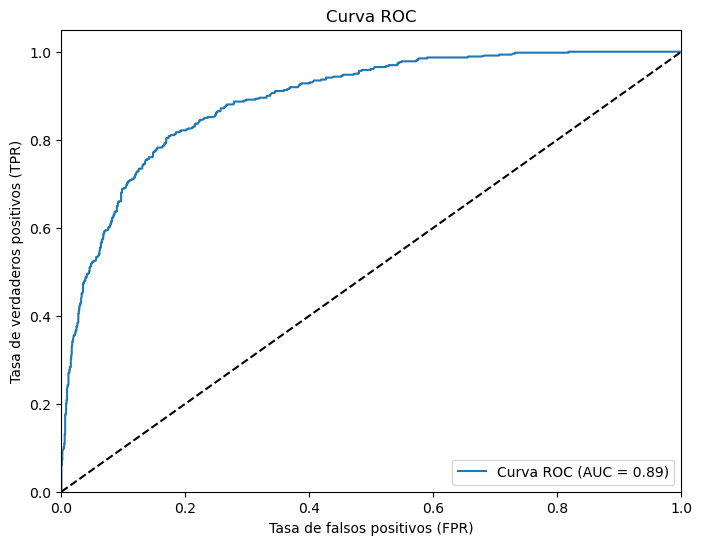

In [191]:
# Obtener las probabilidades para la clase positiva
y_probs = best_model.predict_proba(X_test)[:, 1]

# Calcular la curva ROC
fpr, tpr, thresholds = roc_curve(y_test, y_probs)
roc_auc = auc(fpr, tpr)

# Graficar la curva ROC
plt.figure(figsize=(8,6))
plt.plot(fpr, tpr, label=f'Curva ROC (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], 'k--')  # Línea diagonal
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Tasa de falsos positivos (FPR)')
plt.ylabel('Tasa de verdaderos positivos (TPR)')
plt.title('Curva ROC')
plt.legend(loc="lower right")
plt.show()

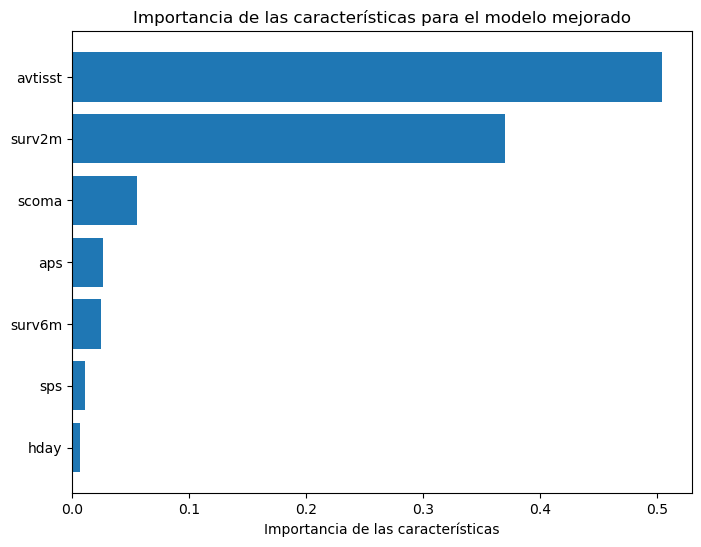

In [195]:
# Obtener la importancia de las características
importance = best_model.feature_importances_

# Ordenar por importancia
sorted_idx = np.argsort(importance)

# Graficar la importancia
plt.figure(figsize=(8,6))
plt.barh(range(len(sorted_idx)), importance[sorted_idx], align='center')
plt.yticks(range(len(sorted_idx)), np.array(X_train.columns)[sorted_idx])
plt.xlabel("Importancia de las características")
plt.title("Importancia de las características para el modelo mejorado")
plt.show()

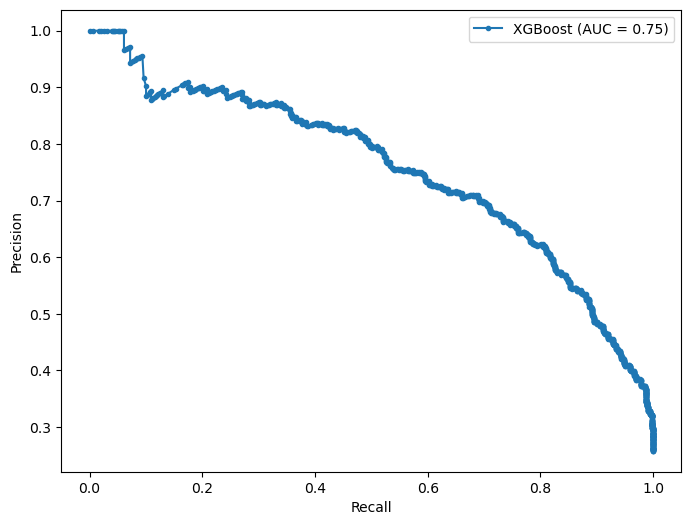

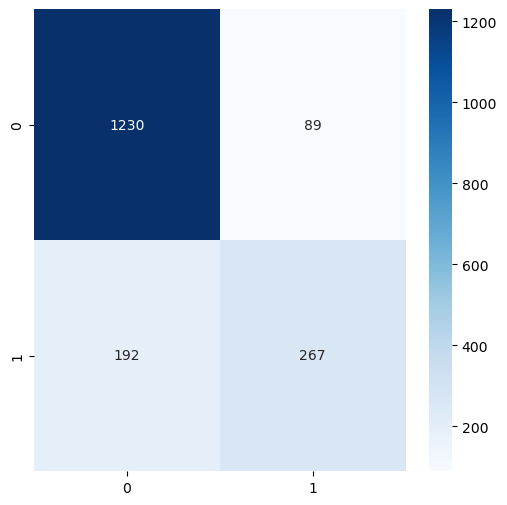

Accuracy: 0.8419572553430821
F1 Score: 0.8349399329293935
Reporte de Clasificación:
              precision    recall  f1-score   support

           0       0.86      0.93      0.90      1319
           1       0.75      0.58      0.66       459

    accuracy                           0.84      1778
   macro avg       0.81      0.76      0.78      1778
weighted avg       0.84      0.84      0.83      1778



In [197]:
# Realizar predicciones
y_test_pred = best_model.predict(X_test)
y_test_probs = best_model.predict_proba(X_test)[:, 1]

# Evaluación de las métricas
accuracy = accuracy_score(y_test, y_test_pred)
f1 = f1_score(y_test, y_test_pred, average='weighted')
classification_rep = classification_report(y_test, y_test_pred, zero_division=0)

# Curva Precision-Recall
lr_precision, lr_recall, _ = precision_recall_curve(y_test, y_test_probs)
lr_auc = auc(lr_recall, lr_precision)

plt.figure(figsize=(8,6))
plt.plot(lr_recall, lr_precision, marker='.', label=f'XGBoost (AUC = {lr_auc:.2f})')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.legend()
plt.show()

# Matriz de confusión
cmat = confusion_matrix(y_test, y_test_pred)
plt.figure(figsize=(6,6))
sns.heatmap(cmat, annot=True, fmt='g', cmap='Blues')
plt.show()

# Mostrar los resultados
print(f"Accuracy: {accuracy}")
print(f"F1 Score: {f1}")
print("Reporte de Clasificación:")
print(classification_rep)

## Submuestreo

Proporciones de las clases antes del submuestreo:
hospdead
0    5258
1    1852
Name: count, dtype: int64

Proporciones de las clases después del submuestreo:
hospdead
0    1852
1    1852
Name: count, dtype: int64


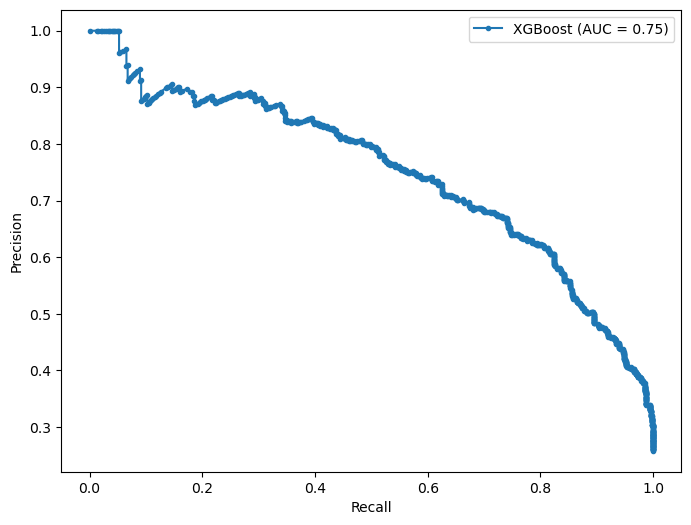

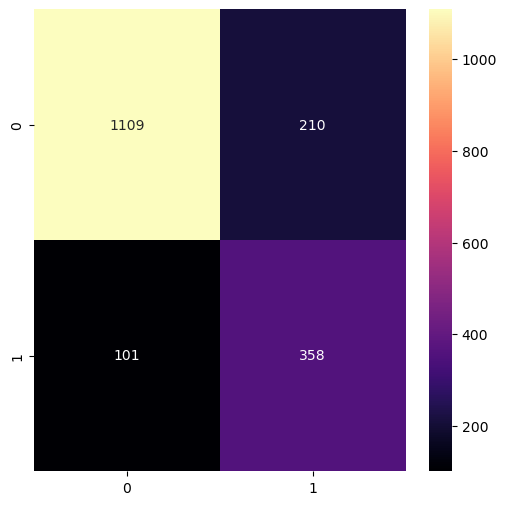

Accuracy: 0.8250843644544432
F1 Score: 0.8305972096122961
Reporte de Clasificación:
              precision    recall  f1-score   support

           0       0.92      0.84      0.88      1319
           1       0.63      0.78      0.70       459

    accuracy                           0.83      1778
   macro avg       0.77      0.81      0.79      1778
weighted avg       0.84      0.83      0.83      1778



In [205]:
# Submuestreo aleatorio para equilibrar las clases
rus = RandomUnderSampler(random_state=58)
X_subsampled, y_subsampled = rus.fit_resample(X_train, y_train)

# Mostrar las proporciones de clases antes y después del submuestreo
print("Proporciones de las clases antes del submuestreo:")
print(pd.Series(y_train).value_counts())

print("\nProporciones de las clases después del submuestreo:")
print(pd.Series(y_subsampled).value_counts())

# Entrenar el modelo con los datos submuestreados
best_model.fit(X_subsampled, y_subsampled)

# Realizar predicciones en el conjunto de prueba
y_test_pred = best_model.predict(X_test)
y_test_probs = best_model.predict_proba(X_test)[:, 1]

# Evaluar el rendimiento
accuracy = accuracy_score(y_test, y_test_pred)
f1 = f1_score(y_test, y_test_pred, average='weighted')
classification_rep = classification_report(y_test, y_test_pred, zero_division=0)

# Curva Precision-Recall
lr_precision, lr_recall, _ = precision_recall_curve(y_test, y_test_probs)
lr_auc = auc(lr_recall, lr_precision)

plt.figure(figsize=(8,6))
plt.plot(lr_recall, lr_precision, marker='.', label=f'XGBoost (AUC = {lr_auc:.2f})')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.legend()
plt.show()

# Matriz de confusión
cmat = confusion_matrix(y_test, y_test_pred)
plt.figure(figsize=(6,6))
sns.heatmap(cmat, annot=True, fmt='g', cmap='magma')
plt.show()

# Mostrar los resultados
print(f"Accuracy: {accuracy}")
print(f"F1 Score: {f1}")
print("Reporte de Clasificación:")
print(classification_rep)


### Aplicación de XGBoost sobre los datos submuestreados

In [207]:
# Definir el modelo a ser entrenado con los datos submuestreados
xgb_model_submuestreado = XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=58)
xgb_model_submuestreado.fit(X_subsampled, y_subsampled)

# Generar la búsqueda aleatoria de hiperparámetros
param_distributions = {
    'n_estimators': randint(30, 200),
    'learning_rate': uniform(0.01, 0.5),
    'max_depth': randint(3, 30),
    'reg_lambda': uniform(0.01, 1)
}

# Configuración de la búsqueda aleatoria
search_under = RandomizedSearchCV(
    estimator=xgb_model_submuestreado,
    param_distributions=param_distributions,
    n_iter=40,
    scoring='f1', 
    cv=StratifiedKFold(n_splits=5),
    random_state=58,
    verbose=10,
    n_jobs=-1
)

# Realizar la búsqueda de hiperparámetros con los datos subsampleados
search_under.fit(X_subsampled, y_subsampled)

# Convertir los resultados en DataFrame para visualizar
resultados_under = pd.DataFrame(search_under.cv_results_)

# Mostrar los mejores resultados y obtener los parámetros del mejor modelo
see_results(resultados_under)
best_model_under = report_best_scores(search_under.cv_results_)
print("Mejores parámetros del modelo con submuestreo:", best_model_under)

# Entrenar el modelo final con los mejores parámetros
final_model_under = XGBClassifier(**best_model_under, use_label_encoder=False, eval_metric='logloss', random_state=13)
final_model_under.fit(X_subsampled, y_subsampled)

# Evaluar el modelo final en el conjunto de prueba
y_test_pred = final_model_under.predict(X_test)
y_test_probs = final_model_under.predict_proba(X_test)[:, 1]

Fitting 5 folds for each of 40 candidates, totalling 200 fits


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_learning_rate,param_max_depth,param_n_estimators,param_reg_lambda,params,mean_test_score,std_test_score,rank_test_score
14,0.061665,0.003096,0.007468,0.000217,0.075853,3,115,0.895823,"{'learning_rate': 0.07585292772691508, 'max_de...",0.823282,0.012964,1
9,0.098403,0.008745,0.010290,0.004647,0.130148,3,183,0.381382,"{'learning_rate': 0.130148304358375, 'max_dept...",0.819572,0.008576,2
28,0.164163,0.005449,0.008744,0.002669,0.068285,7,87,0.623091,"{'learning_rate': 0.06828495478701822, 'max_de...",0.817676,0.006932,3
37,0.047908,0.004492,0.006942,0.003895,0.285936,3,77,0.90655,"{'learning_rate': 0.2859361770419679, 'max_dep...",0.817567,0.007733,4
38,0.071281,0.005152,0.008038,0.003118,0.174899,6,58,0.722147,"{'learning_rate': 0.17489881680299457, 'max_de...",0.815997,0.007366,5
39,0.274779,0.003851,0.003743,0.001724,0.044255,13,75,0.570277,"{'learning_rate': 0.04425464895708497, 'max_de...",0.808011,0.009192,6
27,0.326429,0.009594,0.011874,0.002508,0.079181,9,127,0.06341,"{'learning_rate': 0.07918149429494618, 'max_de...",0.807861,0.010447,7
4,0.193346,0.010141,0.011401,0.000957,0.162969,9,59,0.628478,"{'learning_rate': 0.16296949364222835, 'max_de...",0.807739,0.010486,8
24,0.062632,0.005290,0.006747,0.001639,0.389958,4,83,0.702325,"{'learning_rate': 0.3899576906134333, 'max_dep...",0.806243,0.007185,9
23,0.140546,0.004524,0.009972,0.000890,0.247674,6,135,0.231656,"{'learning_rate': 0.24767396773947897, 'max_de...",0.806012,0.003034,10


Model with rank: 1
Mean validation score: 0.823 (std: 0.013)
Parameters: {'learning_rate': 0.07585292772691508, 'max_depth': 3, 'n_estimators': 115, 'reg_lambda': 0.8958232198023255}
--------------------------------------------------
Model with rank: 2
Mean validation score: 0.820 (std: 0.009)
Parameters: {'learning_rate': 0.130148304358375, 'max_depth': 3, 'n_estimators': 183, 'reg_lambda': 0.38138151011897914}
--------------------------------------------------
Model with rank: 3
Mean validation score: 0.818 (std: 0.007)
Parameters: {'learning_rate': 0.06828495478701822, 'max_depth': 7, 'n_estimators': 87, 'reg_lambda': 0.6230908513682639}
--------------------------------------------------
Mejores parámetros del modelo con submuestreo: {'learning_rate': 0.07585292772691508, 'max_depth': 3, 'n_estimators': 115, 'reg_lambda': 0.8958232198023255}


Accuracy: 0.8188976377952756
F1 Score: 0.8252842505849738
Reporte de Clasificación:
              precision    recall  f1-score   support

           0       0.92      0.83      0.87      1319
           1       0.62      0.79      0.69       459

    accuracy                           0.82      1778
   macro avg       0.77      0.81      0.78      1778
weighted avg       0.84      0.82      0.83      1778



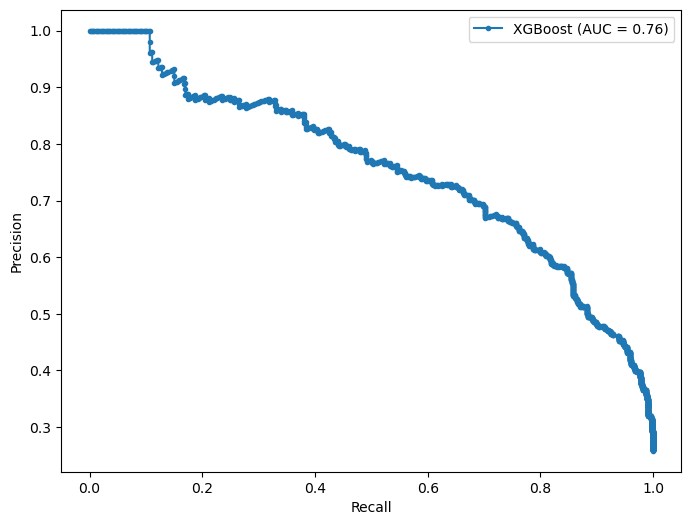

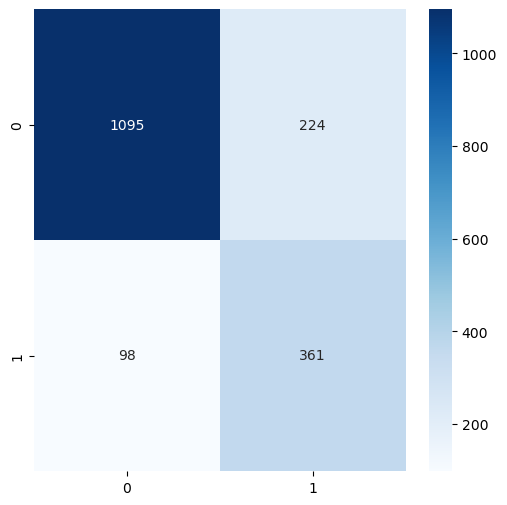

In [209]:
# Calcular las métricas de evaluación
accuracy = accuracy_score(y_test, y_test_pred)
f1 = f1_score(y_test, y_test_pred, average='weighted')
classification_rep = classification_report(y_test, y_test_pred, zero_division=0)

# Mostrar resultados
print(f"Accuracy: {accuracy}")
print(f"F1 Score: {f1}")
print("Reporte de Clasificación:")
print(classification_rep)

# Mostrar la curva Precision-Recall
lr_precision, lr_recall, _ = precision_recall_curve(y_test, y_test_probs)
plt.figure(figsize=(8,6))
plt.plot(lr_recall, lr_precision, marker='.', label=f'XGBoost (AUC = {auc(lr_recall, lr_precision):.2f})')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.legend()
plt.show()

# Mostrar la matriz de confusión
cmat = confusion_matrix(y_test, y_test_pred)
plt.figure(figsize=(6,6))
sns.heatmap(cmat, annot=True, fmt='g', cmap='Blues')
plt.show()

In [211]:
# Entrenamiento del modelo con los mejores parámetros obtenidos para el subsampleo

best_xgb_model_subsampled = XGBClassifier(
    learning_rate=0.07585292772691508, 
    max_depth=3, 
    n_estimators=115,  
    reg_lambda=0.8958232198023255, 
    use_label_encoder=False, 
    eval_metric='logloss',
    random_state=58
)

# Entrenar el modelo con los datos submuestreados
best_xgb_model_subsampled.fit(X_subsampled, y_subsampled)

# Hacer predicciones sobre el conjunto de prueba
y_test_pred_sub = best_xgb_model_subsampled.predict(X_test)
y_test_probs_sub = best_xgb_model_subsampled.predict_proba(X_test)[:, 1]

Accuracy con submuestreo: 0.8188976377952756
F1 Score con submuestreo: 0.8252842505849738
Reporte de Clasificación con submuestreo:
              precision    recall  f1-score   support

           0       0.92      0.83      0.87      1319
           1       0.62      0.79      0.69       459

    accuracy                           0.82      1778
   macro avg       0.77      0.81      0.78      1778
weighted avg       0.84      0.82      0.83      1778



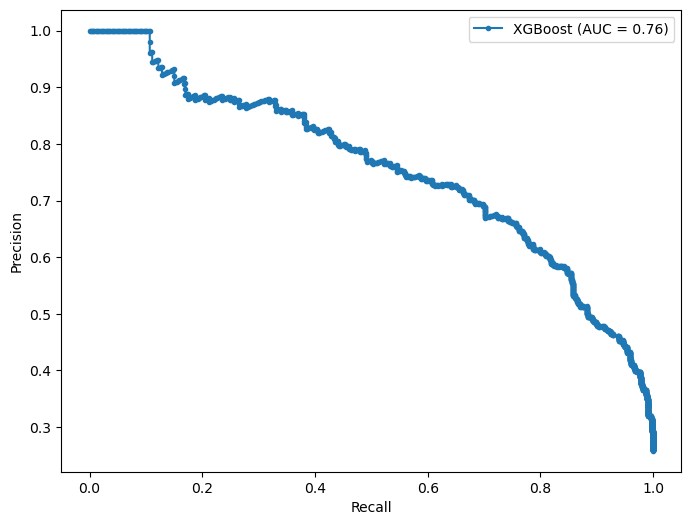

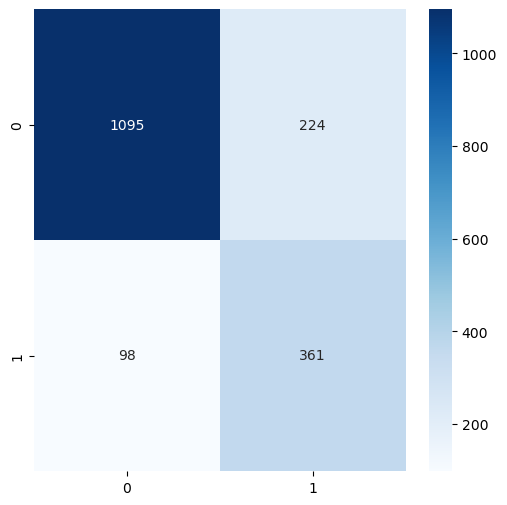

In [213]:
# Evaluación

accuracy_sub = accuracy_score(y_test, y_test_pred_sub)
f1_sub = f1_score(y_test, y_test_pred_sub, average='weighted')
classification_rep_sub = classification_report(y_test, y_test_pred_sub, zero_division=0)

# Mostrar resultados
print(f"Accuracy con submuestreo: {accuracy_sub}")
print(f"F1 Score con submuestreo: {f1_sub}")
print("Reporte de Clasificación con submuestreo:")
print(classification_rep_sub)

# Curva Precision-Recall
lr_precision_sub, lr_recall_sub, _ = precision_recall_curve(y_test, y_test_probs_sub)
plt.figure(figsize=(8,6))
plt.plot(lr_recall_sub, lr_precision_sub, marker='.', label=f'XGBoost (AUC = {auc(lr_recall_sub, lr_precision_sub):.2f})')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.legend()
plt.show()

# Matriz de confusión
cmat_sub = confusion_matrix(y_test, y_test_pred_sub)
plt.figure(figsize=(6,6))
sns.heatmap(cmat_sub, annot=True, fmt='g', cmap='Blues')
plt.show()


## Aplicación de CatBoost

Accuracy con CatBoost: 0.8267716535433071
F1 Score con CatBoost: 0.8324274476470672
Reporte de Clasificación con CatBoost:
              precision    recall  f1-score   support

           0       0.92      0.84      0.88      1319
           1       0.63      0.79      0.70       459

    accuracy                           0.83      1778
   macro avg       0.78      0.81      0.79      1778
weighted avg       0.85      0.83      0.83      1778



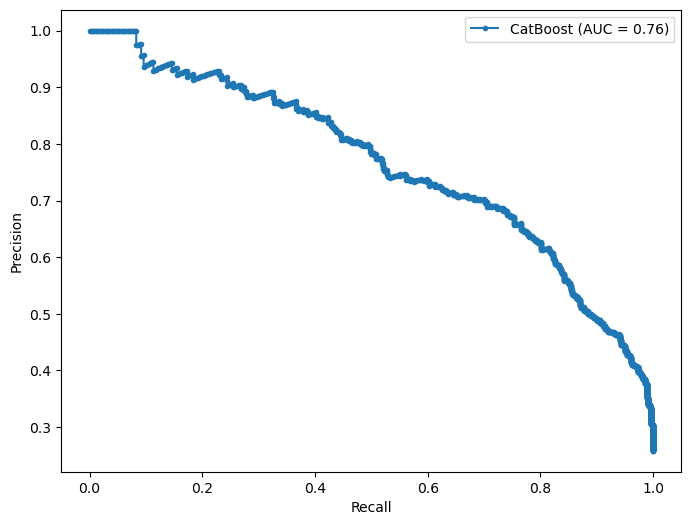

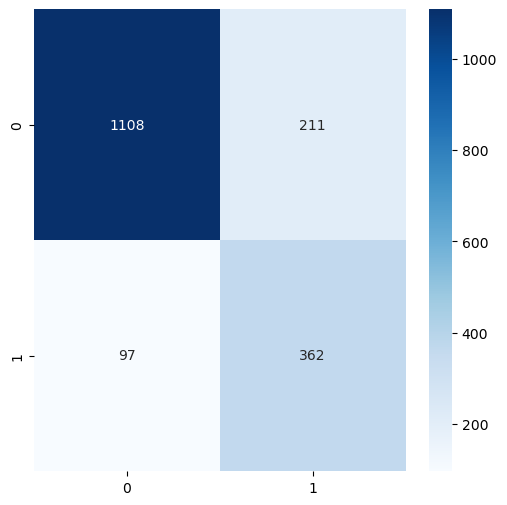

In [219]:
from catboost import CatBoostClassifier

#Modelo CatBoost
catboost_model = CatBoostClassifier(
    learning_rate=0.03, 
    depth=6, 
    iterations=500, 
    random_seed=58,
    verbose=0
)

# Entrenar el modelo con los datos subsampleados
catboost_model.fit(X_subsampled, y_subsampled)

# Realizar predicciones sobre el conjunto de prueba
y_test_pred_cat = catboost_model.predict(X_test)
y_test_probs_cat = catboost_model.predict_proba(X_test)[:, 1]

# Evaluar el modelo
accuracy_cat = accuracy_score(y_test, y_test_pred_cat)
f1_cat = f1_score(y_test, y_test_pred_cat, average='weighted')
classification_rep_cat = classification_report(y_test, y_test_pred_cat, zero_division=0)

# Mostrar resultados
print(f"Accuracy con CatBoost: {accuracy_cat}")
print(f"F1 Score con CatBoost: {f1_cat}")
print("Reporte de Clasificación con CatBoost:")
print(classification_rep_cat)

# Curva Precision-Recall
lr_precision_cat, lr_recall_cat, _ = precision_recall_curve(y_test, y_test_probs_cat)
plt.figure(figsize=(8,6))
plt.plot(lr_recall_cat, lr_precision_cat, marker='.', label=f'CatBoost (AUC = {auc(lr_recall_cat, lr_precision_cat):.2f})')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.legend()
plt.show()

# Matriz de confusión
cmat_cat = confusion_matrix(y_test, y_test_pred_cat)
plt.figure(figsize=(6,6))
sns.heatmap(cmat_cat, annot=True, fmt='g', cmap='Blues')
plt.show()


## Aplicación de LightGBM

In [223]:
!pip install lightgbm

   ---------------------------------------- 0.0/1.4 MB ? eta -:--:--
   ---------------------------------------- 0.0/1.4 MB ? eta -:--:--
    --------------------------------------- 0.0/1.4 MB 435.7 kB/s eta 0:00:04
   - -------------------------------------- 0.1/1.4 MB 409.6 kB/s eta 0:00:04
   -- ------------------------------------- 0.1/1.4 MB 525.1 kB/s eta 0:00:03
   --- ------------------------------------ 0.1/1.4 MB 655.8 kB/s eta 0:00:02
   ---- ----------------------------------- 0.2/1.4 MB 700.2 kB/s eta 0:00:02
   -------- ------------------------------- 0.3/1.4 MB 916.0 kB/s eta 0:00:02
   ----------- ---------------------------- 0.4/1.4 MB 1.1 MB/s eta 0:00:01
   ----------- ---------------------------- 0.4/1.4 MB 1.1 MB/s eta 0:00:01
   ------------- -------------------------- 0.5/1.4 MB 1.1 MB/s eta 0:00:01
   ------------------- -------------------- 0.7/1.4 MB 1.4 MB/s eta 0:00:01
   ------------------------ --------------- 0.9/1.4 MB 1.6 MB/s eta 0:00:01
   -----------

[LightGBM] [Info] Number of positive: 1852, number of negative: 1852
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000466 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1132
[LightGBM] [Info] Number of data points in the train set: 3704, number of used features: 7
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits w

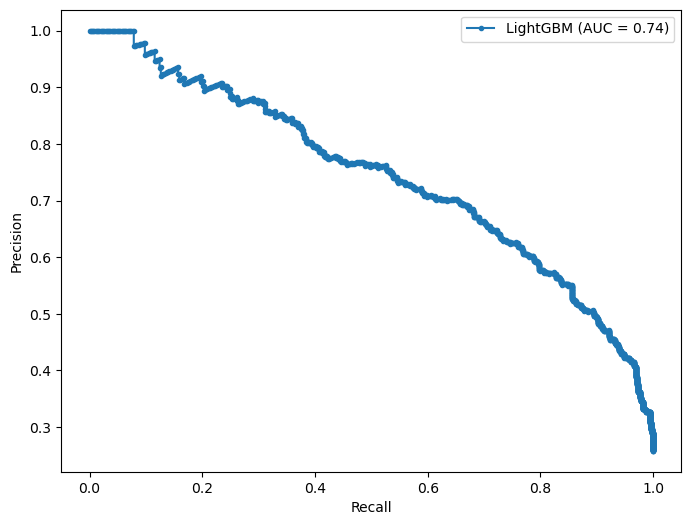

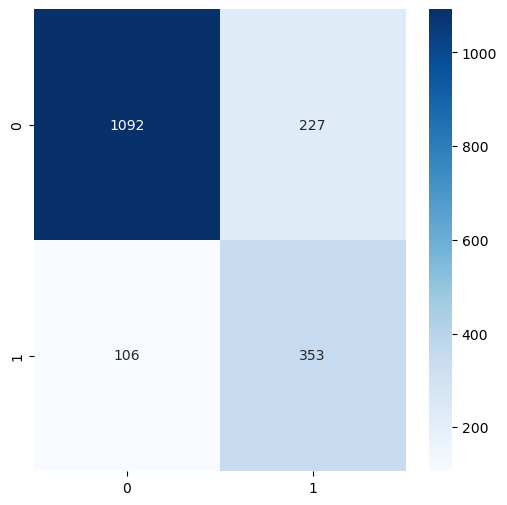

In [225]:
import lightgbm as lgb

#LightGBM
lightgbm_model = lgb.LGBMClassifier(
    learning_rate=0.03, 
    max_depth=6, 
    n_estimators=500, 
    random_state=58
)

# Entrenar el modelo con los datos subsampleados
lightgbm_model.fit(X_subsampled, y_subsampled)

# Realizar predicciones sobre el conjunto de prueba
y_test_pred_lgb = lightgbm_model.predict(X_test)
y_test_probs_lgb = lightgbm_model.predict_proba(X_test)[:, 1]

# Evaluar el modelo
accuracy_lgb = accuracy_score(y_test, y_test_pred_lgb)
f1_lgb = f1_score(y_test, y_test_pred_lgb, average='weighted')
classification_rep_lgb = classification_report(y_test, y_test_pred_lgb, zero_division=0)

# Mostrar resultados
print(f"Accuracy con LightGBM: {accuracy_lgb}")
print(f"F1 Score con LightGBM: {f1_lgb}")
print("Reporte de Clasificación con LightGBM:")
print(classification_rep_lgb)

# Curva Precision-Recall
lr_precision_lgb, lr_recall_lgb, _ = precision_recall_curve(y_test, y_test_probs_lgb)
plt.figure(figsize=(8,6))
plt.plot(lr_recall_lgb, lr_precision_lgb, marker='.', label=f'LightGBM (AUC = {auc(lr_recall_lgb, lr_precision_lgb):.2f})')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.legend()
plt.show()

# Matriz de confusión
cmat_lgb = confusion_matrix(y_test, y_test_pred_lgb)
plt.figure(figsize=(6,6))
sns.heatmap(cmat_lgb, annot=True, fmt='g', cmap='Blues')
plt.show()


**Resultados:** El modelo de Random Forest obtuvo un accuracy de 0.8465, con una precisión de 0.8405, un recall de 0.8465 y un F1-score de 0.8410. La matriz de confusión muestra que para la Clase 0 (no mortalidad hospitalaria), el modelo logró un 93% de recall, mientras que para la Clase 1 (mortalidad hospitalaria), el recall fue del 61% y el F1-score del 67%. 

El modelo de XGBoost arrojó un accuracy promedio de 0.8376 tras validación cruzada, con una precisión ponderada de 0.8324, un recall ponderado de 0.8376 y un F1-score ponderado de 0.8339. El mejor modelo de XGBoost alcanzó un accuracy de 0.8420, una precisión de 0.8353, un recall de 0.8420 y un F1-score de 0.8349. En la matriz de confusión, para la Clase 0 el recall fue del 93%, mientras que para la Clase 1 fue del 58%, con un F1-score de 66%. 

Al aplicar submuestreo con XGBoost, el modelo obtuvo un accuracy de 0.8189 y un F1-score de 0.8253. El mejor modelo tras la búsqueda de hiperparámetros alcanzó un accuracy de 0.823, con una precisión de 0.92 para la Clase 0 y de 0.62 para la Clase 1. El F1-score fue de 0.87 para la Clase 0 y de 0.69 para la Clase 1. La matriz de confusión muestra que el modelo mejoró el recall para la Clase 1 (mortalidad hospitalaria) en comparación con los modelos sin submuestreo.

El modelo de CatBoost tuvo un accuracy de 0.8268 y un F1-score de 0.8324. En la matriz de confusión, el modelo logró un recall del 84% para la Clase 0 y del 79% para la Clase 1, con una precisión del 92% para la Clase 0 y del 63% para la Clase 1. El F1-score para la Clase 1 fue de 70%. El rendimiento de CatBoost fue superior en términos de recall para la Clase 1 en comparación con los modelos anteriores.

El modelo de LightGBM alcanzó un accuracy de 0.8127 y un F1-score de 0.8191. En la matriz de confusión, para la Clase 0 el modelo obtuvo un recall del 83%, mientras que para la Clase 1 el recall fue del 77%. La precisión para la Clase 1 fue de 61%, con un F1-score de 68%. El rendimiento de LightGBM fue ligeramente inferior al de CatBoost y XGBoost, especialmente en la detección de la Clase 1.

 

**Conclusiones:** A partir de los resultados obtenidos, se puede concluir que *CatBoost** ofrece el mejor balance entre precisión y recall, especialmente en la detección de casos de mortalidad hospitalaria (Clase 1), con un recall del 79% y un F1-score de 70%. XGBoost con submuestreo también mostró mejoras significativas en la clase minoritaria, aumentando el recall a 62%, aunque su rendimiento general es ligeramente inferior al de CatBoost. Random Forest y XGBoost sin submuestreo son modelos competitivos, pero presentan menor capacidad para detectar la Clase 1, con recall alrededor del 60%. Finalmente, LightGBM mostró el rendimiento más bajo, con un recall de 77% para la Clase 1, y menor precisión en general comparado con los demás modelos.a.